In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import KFold

In [2]:
spacing = {
    "single_ch":    [14.3, 15.3, 16.3, 17.8, 19.3, 21.3, 23.3, 26.3, 28.3, 31.3, 36.3],
    "18GHz":        [18, 19, 20, 23, 25, 27, 30, 32, 35, 40],
    # "17.6GHz":      [18, 19, 20, 21.5, 23, 25, 27, 30, 32, 35, 40], # Uncomment if you have data for 17.6GHz
    "17GHz":        [18, 19, 20, 21.5, 23, 25, 27, 30, 32, 35, 40],
    "16.5GHz":      [18, 19, 20, 21.5, 23, 25, 27, 30, 32, 35, 40],
    "16GHz":        [18, 19, 20, 21.5, 23, 25, 27, 30, 32, 35, 40],
    "15.5GHz":      [20, 21.5, 23, 25, 27, 30, 32, 35, 40],
    "15GHz":        [23, 25, 27, 30, 32, 35, 40],
}

In [3]:
images = []
labels = []

for i in spacing.keys():
    for j in spacing[i]:
        for k in range(9):
            # Load the image in RGB format
            img = cv2.imread(f"constellations/{i}/{j}_dB_sample_{k}.png")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.GaussianBlur(img, (5, 5), 0)
            img = img.astype(np.float32) / 255.0
            images.append(img)

            # Find the labels for the images
            if i == "single_ch":
                labels.append(0)
            elif i == "18GHz":
                labels.append(0)
            elif i == "17.6GHz":
                labels.append(0)
            elif i == "17GHz":
                labels.append(1)
            elif i == "16.5GHz":
                labels.append(1)
            elif i == "16GHz":
                labels.append(1)
            elif i == "15.5GHz":
                labels.append(1)
            elif i == "15GHz":
                labels.append(1)
            else:
                labels.append(-1)

images = np.array(images)
labels = np.array(labels)

In [4]:
n_classes = len(np.unique(labels))
input_shape = images[0].shape

print("Num. classes: ", n_classes)
print("Input shape: ", input_shape)

Num. classes:  2
Input shape:  (64, 64, 3)


In [5]:
def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(n_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [6]:
kf = KFold(n_splits=5, shuffle=True)
accuracies = []
losses = []
histories = []

for train_index, test_index in kf.split(images):
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    model = create_model()
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test))
    loss, acc = model.evaluate(X_test, y_test, verbose=1)
    accuracies.append(acc)
    losses.append(loss)
    histories.append(history)




Epoch 1/100


16/16 [==============================] - 3s 74ms/step - loss: 0.6251 - accuracy: 0.6905 - val_loss: 0.5604 - val_accuracy: 0.7302
Epoch 2/100
16/16 [==============================] - 1s 42ms/step - loss: 0.6050 - accuracy: 0.7044 - val_loss: 0.5711 - val_accuracy: 0.7302
Epoch 3/100
16/16 [==============================] - 1s 40ms/step - loss: 0.5730 - accuracy: 0.7163 - val_loss: 0.5545 - val_accuracy: 0.7698
Epoch 4/100
16/16 [==============================] - 1s 39ms/step - loss: 0.5778 - accuracy: 0.7202 - val_loss: 0.5991 - val_accuracy: 0.6905
Epoch 5/100
16/16 [==============================] - 1s 42ms/step - loss: 0.5496 - accuracy: 0.7321 - val_loss: 0.5558 - val_accuracy: 0.7698
Epoch 6/100
16/16 [==============================] - 1s 39ms/step - loss: 0.5554 - accuracy: 0.7460 - val_loss: 0.5397 - val_accuracy: 0.7619
Epoch 7/100
16/16 [==============================] - 1s 39ms/step - loss: 0.5945 - accuracy: 0.7183 - val_loss: 0.5798 - val_accuracy: 0.7778
E

Best accuracy: 92.86%
Best loss: 0.37


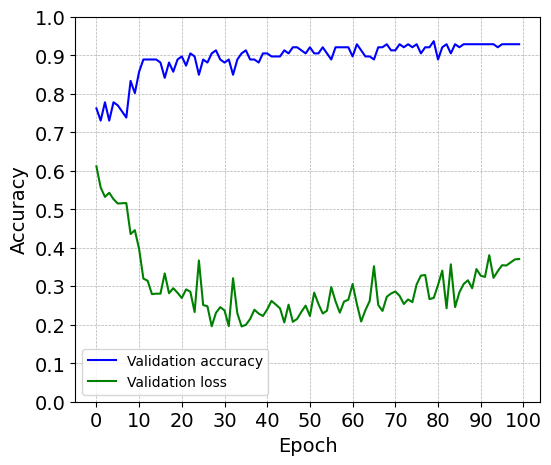

In [14]:
best_acc_index = np.argmax(accuracies)
best_acc = accuracies[best_acc_index]
best_loss = losses[best_acc_index]
best_history = histories[best_acc_index]

print(f"Best accuracy: {(best_acc * 100):.2f}%")
print(f"Best loss: {best_loss:.2f}")

plt.figure(figsize=(6, 5))
plt.plot(best_history.history['val_accuracy'], c='b', label='Validation accuracy')
plt.plot(best_history.history['val_loss'], c='g', label='Validation loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(np.arange(0, 101, 10), fontsize=14)
plt.yticks(np.arange(0, 1.05, 0.1), fontsize=14)
plt.legend()
plt.grid(linestyle='--', linewidth=0.5)
plt.show()